In [1]:
"""
This notebook plots the performance of CLIPNET.
We use averaged profiles across all 67 libraries as ground truth.
"""

'\nThis notebook plots the performance of CLIPNET.\nWe use averaged profiles across all 67 libraries as ground truth.\n'

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, gaussian_kde
from sklearn.linear_model import LinearRegression

from matplotlib.colors import LinearSegmentedColormap
import mpl_scatter_density # needed for density scatter plots
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# COLORS:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (1e-20, "#440053"),
    (0.2, "#404388"),
    (0.4, "#2a788e"),
    (0.6, "#21a784"),
    (0.8, "#78d151"),
    (1, "#fde624"),
], N=256)
# "Viridis-like" colormap with white background
white_viridis_r = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (1e-20, "#fde624"),
    (0.4, "#78d151"),
    (0.6, "#21a784"),
    (0.7, "#2a788e"),
    (0.8, "#404388"),
    (1, "#440053"),
], N=256)
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

In [2]:
# PRINT COMMANDS TO DOWNLOAD AND EXTRACT DATA

# Set scratch to where you want to download data to
SCRATCH = "/Users/adamhe/github/scratch"

URL = "https://zenodo.org/records/13771189/files"
TAR = "evaluation_metric.tar.gz"
print(f"wget {URL}/{TAR} -P {SCRATCH}")
print(f"tar -xvzf {SCRATCH}/{TAR}")

wget https://zenodo.org/records/13771189/files/evaluation_metric.tar.gz -P /Users/adamhe/github/scratch
tar -xvzf /Users/adamhe/github/scratch/evaluation_metric.tar.gz


In [3]:
# LOAD DATA

# Negative and positive bounds for model performance on correlation
mean_predictor_corr = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/mean_predictor_corrs.csv.gz"), index_col=0,
)
replicate_corr = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/replicate_pearsons.csv.gz"), index_col=0,
)

# Load profile pearsons
clipnet_pearson = h5py.File(
    os.path.join(SCRATCH, "evaluation_metric/merged_performance_0.h5")
)["track_pearson"][:]
puffin = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/puffin_clipnet_test_profile_corr.csv.gz"), index_col=0
)

# Load model predictions
clipnet = h5py.File(
    os.path.join(SCRATCH, "evaluation_metric/merged_prediction_0.h5")
)

# Load quantity predictions
merged_quantity = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/merged_procap_0.csv.gz"), index_col=0, header=None
).to_numpy()[:, np.r_[250:750, 1250:1750]].sum(axis=1)

# Apply affine correction transform to predicted quantities.
log_quantity = pd.DataFrame(
    {
        "clipnet": (
            np.hstack(
                [
                    np.log10(clipnet["quantity"][:, :1]),
                    np.ones((clipnet["quantity"].shape[0], 1)),
                ]
            )
            @ np.array([[1.59687745, -0.80203685]]).T
        ).squeeze(),
        "expt": np.log10(merged_quantity),
    }
)


# Load TSS predictions
clipnet_tss_pl = clipnet["track"][:, :500].argmax(axis=1)
clipnet_tss_mn = clipnet["track"][:, 500:].argmax(axis=1)
merged_tss_pl = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/merged_procap_0.csv.gz"), index_col=0, header=None
).to_numpy()[:, 250:750].argmax(axis=1)
merged_tss_mn = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/merged_procap_0.csv.gz"), index_col=0, header=None
).to_numpy()[:, 1250:1750].argmax(axis=1)

tss = pd.DataFrame(
    {
        "clipnet": np.concatenate([clipnet_tss_pl, clipnet_tss_mn]),
        "expt": np.concatenate([merged_tss_pl, merged_tss_mn]),
    }
)

0.10889751396427025 0.5392279031073643 0.761159750664919 0.8102292015683279


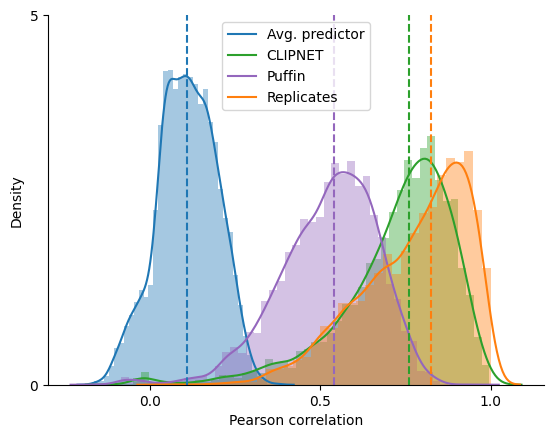

In [4]:
# Plot pdf of predicted vs observed pearson correlations

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

fig, d = plt.subplots()
sns.distplot(mean_predictor_corr, color=colors[0])
sns.distplot(clipnet_pearson, color=colors[2])
sns.distplot(puffin, color=colors[4])
sns.distplot(replicate_corr.mean(axis=1), color=colors[1])
plt.axvline(np.nanmedian(mean_predictor_corr), 0, 1, color=colors[0], linestyle="--")
plt.axvline(np.nanmedian(replicate_corr), 0, 1, color=colors[1], linestyle="--")
plt.axvline(np.nanmedian(clipnet_pearson), 0, 1, color=colors[2], linestyle="--")
plt.axvline(np.nanmedian(puffin), 0, 1, color=colors[4], linestyle="--")
d.set_yticks([0, 5])
#d.set_yticklabels(["", ""])
d.set_xticks([0, 0.5, 1])
#d.set_xticklabels(["", "", ""])
d.set_ylabel("Density")
d.set_xlabel("Pearson correlation")
plt.legend(["Avg. predictor", "CLIPNET", "Puffin", "Replicates"])
sns.despine()
#plt.savefig("img/pearson_kde.pdf")

print(
    np.nanmedian(mean_predictor_corr),
    np.nanmedian(puffin),
    np.nanmedian(clipnet_pearson),
    np.nanmedian(replicate_corr.mean(axis=1))
)

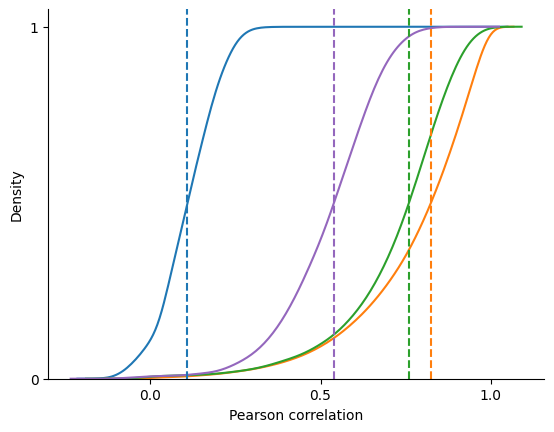

In [82]:
# Plot cdfs of pearson correlations (not used in paper, but here for completion's sake)

fig, d = plt.subplots()
sns.kdeplot(list(mean_predictor_corr["0"]) + [1], cumulative=True)
sns.kdeplot(replicate_corr.values.reshape(-1), cumulative=True)
sns.kdeplot(clipnet_pearson.reshape(-1), cumulative=True)
sns.kdeplot(puffin.values.reshape(-1), color=colors[4], cumulative=True)
plt.axvline(np.nanmedian(mean_predictor_corr), 0, 1, color=colors[0], linestyle="--")
plt.axvline(np.nanmedian(replicate_corr), 0, 1, color=colors[1], linestyle="--")
plt.axvline(np.nanmedian(clipnet_pearson), 0, 1, color=colors[2], linestyle="--")
plt.axvline(np.nanmedian(puffin), 0, 1, color=colors[4], linestyle="--")
d.set_yticks([0, 1])
#d.set_yticklabels(["", ""])
d.set_xticks([0, 0.5, 1])
#d.set_xticklabels(["", "", ""])
d.set_ylabel("Density")
d.set_xlabel("Pearson correlation")
sns.despine()
plt.savefig("img/pearson_cdf.pdf")

PearsonRResult(statistic=0.7339278710104438, pvalue=0.0)
SignificanceResult(statistic=0.7354219554215649, pvalue=0.0)


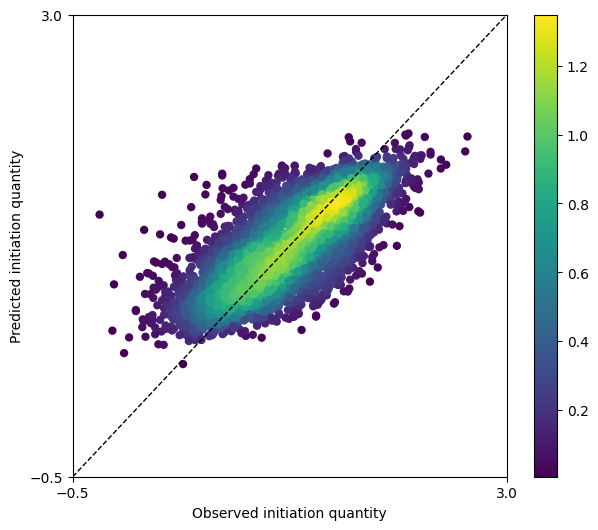

In [6]:
# Plot predicted vs observed log quantities

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
ax = sns.scatterplot(
    data=log_quantity,
    x="expt",
    y="clipnet",
    c=gaussian_kde(log_quantity.transpose())(log_quantity.transpose()),
    cmap="viridis",
    alpha=1,
    linewidth=0,
)
fig.colorbar(ax.collections[0], ax=ax, orientation="vertical")
ax.set_xlim(-0.5, 3)
ax.set_ylim(-0.5, 3)
ax.set_xticks([-0.5, 3])
#ax.set_xticklabels(["", ""])
ax.set_yticks([-0.5, 3])
#plt.axhline(np.log10(10**(np.log10(12.593226469243358) * 1.59687745 - 0.80203685)), color="black", linestyle="--", linewidth=1)
#plt.axvline(np.log10(1.357), color="black", linestyle="--", linewidth=1)
#ax.set_yticklabels(["", ""])
ax.set_ylabel("Predicted initiation quantity")
ax.set_xlabel("Observed initiation quantity")

ax.plot([-0.5, 3], [-0.5, 3], color="black", linestyle="--", linewidth=1)
plt.savefig("img/log_quantity.pdf")

print(pearsonr(log_quantity.expt, log_quantity.clipnet))
print(spearmanr(log_quantity.expt, log_quantity.clipnet))

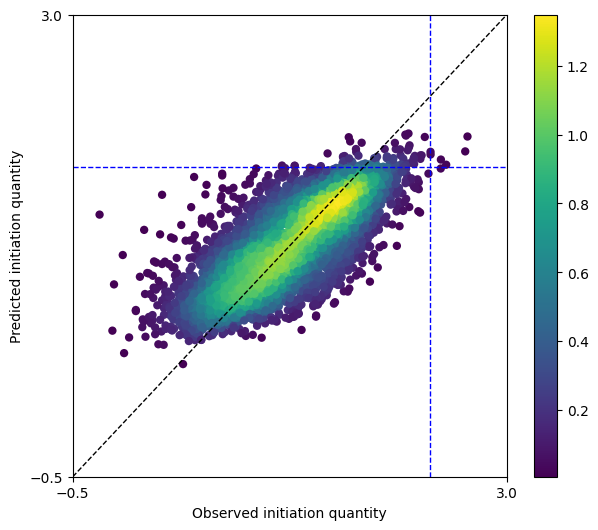

In [14]:
# Plot predicted vs observed log quantities

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
ax = sns.scatterplot(
    data=log_quantity,
    x="expt",
    y="clipnet",
    c=gaussian_kde(log_quantity.transpose())(log_quantity.transpose()),
    cmap="viridis",
    alpha=1,
    linewidth=0,
)
fig.colorbar(ax.collections[0], ax=ax, orientation="vertical")
ax.set_xlim(-0.5, 3)
ax.set_ylim(-0.5, 3)
ax.set_xticks([-0.5, 3])
#ax.set_xticklabels(["", ""])
ax.set_yticks([-0.5, 3])
plt.axhline(1.850098262678154, color="blue", linestyle="--", linewidth=1)
plt.axvline(2.377, color="blue", linestyle="--", linewidth=1)
#ax.set_yticklabels(["", ""])
ax.set_ylabel("Predicted initiation quantity")
ax.set_xlabel("Observed initiation quantity")

ax.plot([-0.5, 3], [-0.5, 3], color="black", linestyle="--", linewidth=1)
plt.savefig("img/ints6_log_quantity.pdf")

PearsonRResult(statistic=0.7399901117824242, pvalue=0.0)


/Users/adamhe/miniforge3/envs/plt/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/adamhe/miniforge3/envs/plt/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


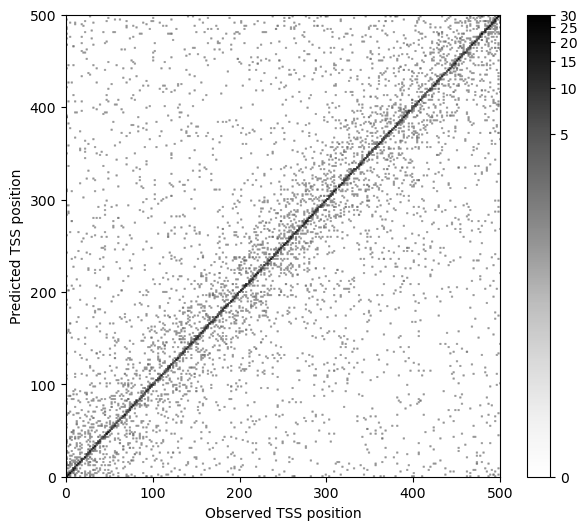

In [9]:
# Plot predicted vs observed TSS position (colored by log density)

norm = ImageNormalize(stretch=LogStretch())

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
log_density = ax.scatter_density(
    x=tss["expt"],
    y=tss["clipnet"],
    cmap="Greys",
    norm=norm,
)
fig.colorbar(log_density)
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
ax.set_ylabel("Predicted TSS position")
ax.set_xlabel("Observed TSS position")
plt.savefig("img/tss.pdf")

print(pearsonr(tss.expt, tss.clipnet))

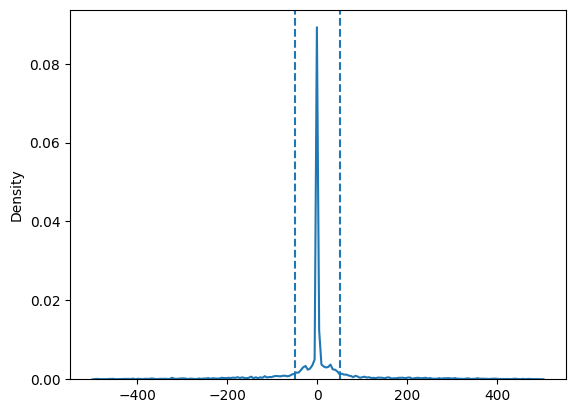

In [30]:
# Here we plot the distribution of distances between predicted and observed TSS

tss_deviation = tss["clipnet"]-tss["expt"]
sns.kdeplot(tss_deviation, bw_adjust=0.1)
plt.axvline(-50, 0, 1, linestyle="--")
plt.axvline(50, 0, 1, linestyle="--")
plt.savefig("img/tss_deviation_kde.pdf")

In [34]:
tss_deviation[(tss_deviation >= -50) & (tss_deviation <= 50)].shape[0] / tss_deviation.shape[0]

0.7445628534145281

/Users/adamhe/miniforge3/envs/plt/lib/python3.13/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/adamhe/miniforge3/envs/plt/lib/python3.13/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


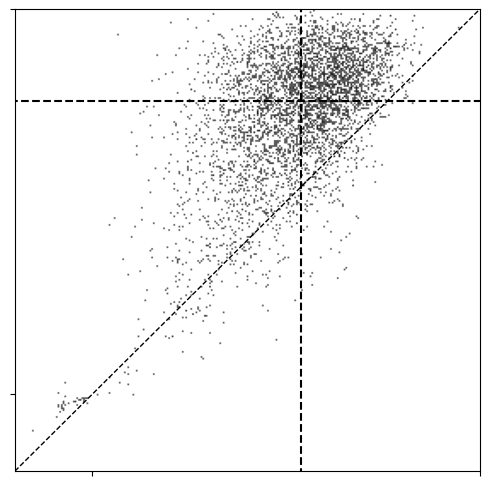

In [59]:
# Plot CLIPNET vs Puffin Pearson scatterplot

norm = ImageNormalize(stretch=LogStretch())
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
density = ax.scatter_density(y=clipnet_pearson, x=puffin.values.flatten(), cmap="Greys", norm=norm)
#density = sns.scatterplot(y=clipnet_pearson, x=puffin.squeeze(), ax=ax, alpha=0.15, s=15, )
#fig.colorbar(density)
plt.axhline(np.nanmedian(clipnet_pearson), -0.2, 1, color="Black", linestyle="--")
plt.axvline(np.nanmedian(puffin), -0.2, 1, color="Black", linestyle="--")
# Add diagonal line
ax.plot([-0.2, 1], [-0.2, 1], color="black", linestyle="--", linewidth=1)
ax.set_xlim(-0.2, 1)
ax.set_ylim(-0.2, 1)
ax.set_yticks([-0, 1])
ax.set_yticklabels(["", ""])
ax.set_xticks([-0, 1])
ax.set_xticklabels(["", ""])
plt.savefig("img/puffin_comparison_pearson_scatterplot.pdf")

In [37]:
puffin.values.flatten()

array([0.37795137, 0.41658893, 0.4183373 , ..., 0.4741195 , 0.47411716,
       0.49441061])

In [16]:
10 ** (2.377)

238.2319469358689